In [8]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [66]:
C = np.array([1, 0]) # |C>
D = np.array([0, 1]) # |D>

# U(θ, φ); return a 2x2 nparray
def U(theta: float, phi: float):
    uni = np.array([[np.exp(1j * phi) * np.cos(theta/2), np.sin(theta/2)],
                    [-np.sin(theta/2), np.exp(-1j * phi) * np.cos(theta/2)]])
    return uni
#done in roughly 19 minutes; most of the time was just spent looking up syntax

#Define Operators/strategies
C_op = U(0, 0)
D_op = U(np.pi, 0)
Q_op = U(0, np.pi/2)

#gamma within the range 0 -> pi/2; entanglement increases as gamma increases
#Get unitary Operator J; 9 minutes
def J(gamma):
    return expm(np.kron(-1j*gamma*D_op, Q_op/2))

#get final state vector; should return 4x1 array (complex)
#48 minutes; @ not * and forgot conj()
def final_state(U_A: np.ndarray, U_B: np.ndarray, J: np.ndarray, initial_state: np.ndarray):
    fs_vect = J.conj().transpose() @ np.kron(U_A, U_B) @ J @ initial_state
    return fs_vect

#Alice's payoff; return a float
#24 minutes;
def payoff_A(final_state: np.ndarray):

    reward = np.array([3,0,5,1])
    
    return np.abs(final_state)**2@reward

def payoff_B(final_state: np.ndarray):

    reward = np.array([3,5,0,1])
    
    return np.abs(final_state)**2@reward

def total_payoff(final_state: np.ndarray):

    
    return payoff_A(final_state)+payoff_B(final_state)
    

# After implementing these, test with all classical strategies (C and D) to verify correctness.
# Tests; 5 minutes
print(payoff_A(final_state(C_op, D_op, J(1), np.kron(C,C)))) #Alice Cooperate, Bob Defect -> (1.1248198369963932e-32+0j); essentially 0
print(payoff_A(final_state(D_op, D_op, J(0), np.kron(C,C)))) #Alice Defect, Bob Defect -> (1+0j);
print(payoff_A(final_state(C_op, C_op, J(0), np.kron(C,C)))) #Alice Cooperate, Bob Cooperate -> (3+0j);
print(payoff_A(final_state(D_op, C_op, J(0), np.kron(C,C)))) #Alice Defect, Bob Cooperate -> (5+0j);


0.7080734182735712
1.0
3.0
5.0


In [10]:
def negative_alice_payoff(params, opponent_move):
    """
    Compute the negative of Alice's payoff for given strategy parameters and an opponent's move.
    
    Parameters:
        params (list or tuple): A pair [theta, phi] defining Alice's unitary strategy U(theta, phi).
        opponent_move (np.ndarray): Bob's strategy represented as a 2x2 unitary matrix.
    
    Returns:
        float: The negative of Alice's expected payoff computed from the final state of the game.
        
    Process:
        1. Construct Alice's strategy using U(theta, phi) with parameters from 'params'.
        2. Prepare the entanglement operator J at maximum entanglement (gamma = π/2).
        3. Define the initial state as a tensor product of two |C> states.
        4. Compute the final state vector by applying:
           a. The entanglement operator J to the initial state.
           b. The tensor product of Alice's and Bob's strategies.
           c. The inverse of the entanglement operator (via its conjugate transpose).
        5. Calculate Alice's payoff using the defined payoff function.
        6. Return the negative payoff (often used in optimization contexts where minimization is performed).
    """
    # Extract strategy parameters: theta and phi for Alice's move
    theta, phi = params[0], params[1]
    
    # Compute Alice's unitary strategy using the given parameters
    alice_move = U(theta, phi)
    
    # Maximum entanglement operator (gamma = π/2)
    entanglement_operator = J(np.pi/2)
    
    # Initial state: tensor product of |C> for Alice and |C> for Bob
    initial_state = np.kron(C, C)
    
    # Compute the final state after applying entanglement, strategies, and disentanglement
    final = final_state(alice_move, opponent_move, entanglement_operator, initial_state)
    
    # Calculate Alice's expected payoff from the final state
    alice_payoff = payoff_A(final)
    
    # Return the negative payoff (useful for minimization routines)
    return -alice_payoff


In [44]:
np.real(f([0,0],C_op))

np.float64(-3.0)

In [31]:
from scipy.optimize import minimize
import numpy as np

def optimize_strategy(initial_guess, opponent_move):
    """
    Optimize Alice's strategy given an opponent's move by minimizing the negative payoff.

    Parameters:
        initial_guess (list): Initial guess [theta, phi] for the optimization.
        opponent_move (np.ndarray): Opponent's move represented as a 2x2 unitary matrix.

    Returns:
        tuple: Optimized strategy parameters (theta, phi) from the minimization.
    
    Process:
        - Uses 'minimize' to find the strategy that maximizes Alice's payoff
          (by minimizing the negative payoff function negative_alice_payoff).
        - The search is bounded: theta ∈ [0, π] and phi ∈ [0, π/2].
    """
    # Boundaries for theta and phi
    bounds = [(0, np.pi), (0, np.pi/2)]
    
    # Perform optimization to minimize negative payoff function negative_alice_payoff
    result = minimize(negative_alice_payoff, initial_guess, args=(opponent_move,), bounds=bounds)
    
    # Extract the optimized strategy parameters
    theta_opt, phi_opt = result.x
    return theta_opt, phi_opt

def has_converged(previous, current, tolerance):
    """
    Check if the strategy parameters have converged.

    Parameters:
        previous (tuple): Previous strategy parameters (theta, phi).
        current (tuple): Current strategy parameters (theta, phi).
        tolerance (float): Convergence threshold.
    
    Returns:
        bool: True if both theta and phi changes are within the tolerance, False otherwise.
    """
    theta_prev, phi_prev = previous
    theta_curr, phi_curr = current
    
    # Compute absolute differences for theta and phi
    delta_theta = np.abs(theta_curr - theta_prev)
    delta_phi = np.abs(phi_curr - phi_prev)
    
    return (delta_theta <= tolerance) and (delta_phi <= tolerance)

def response_chain(start):
    """
    Iteratively optimize Alice's strategy in response to her own previous move.

    Parameters:
        start (tuple): Initial strategy parameters (theta, phi) for Alice.
    
    Returns:
        int: The number of iterations required for the strategy to converge.
    
    Process:
        1. Initialize the strategy history lists for theta and phi.
        2. Set the initial opponent move using U with the starting parameters.
        3. Iteratively optimize the strategy using 'optimize_strategy'.
           - After each optimization, update the current move.
           - Continue until the change in both theta and phi between iterations is below π/500.
        4. Return the total iteration count.
    """
    # Convergence tolerance for strategy parameter changes
    tolerance = np.pi / 500
    
    # Initialize lists to store strategy parameters history
    thetas = []
    phis = []
    
    # Unpack the initial starting parameters
    theta, phi = start
    # Dummy initial values to ensure first iteration (values far from any realistic parameter)
    thetas.append(100)
    phis.append(100)
    
    # Record the starting strategy parameters
    thetas.append(theta)
    phis.append(phi)
    
    # Compute the initial move using the unitary operator U
    current_move = U(theta, phi)
    
    iteration_count = 0
    # Continue iterations until both theta and phi converge within the tolerance
    print(thetas)
    while (np.abs(thetas[-1] - thetas[-2]) > tolerance or 
           np.abs(phis[-1] - phis[-2]) > tolerance):
        iteration_count += 1
        
        # Initial guess for the optimization; can be updated or kept constant as needed
        initial_guess = [np.pi/2, np.pi/4]
        
        # Optimize strategy given the current opponent move
        theta, phi = optimize_strategy(initial_guess, current_move)
        print(theta)
        
        # Append the new strategy parameters to history lists
        thetas.append(theta)
        phis.append(phi)
        
        # Update the current move using the optimized strategy parameters
        current_move = U(theta, phi)
    
    # Convert history lists to numpy arrays if needed (excluding the dummy first value)
    thetas = np.array(thetas[1:])
    phis = np.array(phis[1:])
    
    return (thetas,phis)


[100, 0]
3.141592653589793
0.0
0.0


/tmp/ipykernel_606961/1613416090.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(thetas, phis,s = 150, c=colors, cmap='viridis', edgecolor='none', zorder = 100)


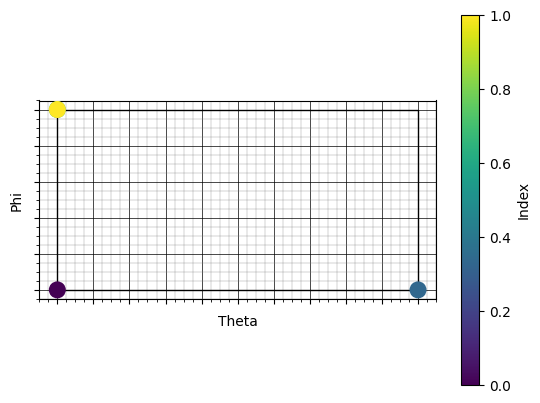

In [32]:
# Normalize indices for color mapping
thetas,phis = response_chain((0,0))

indices = np.arange(len(thetas))
norm = plt.Normalize(indices.min(), indices.max())
colors = plt.cm.viridis(norm(indices))  # Viridis colormap from red to blue

# Box around original boundaries
plt.plot([0, np.pi, np.pi, 0, 0], [0, 0, np.pi/2, np.pi/2, 0], 'k', linewidth=1)

# Adding gridlines
plt.xticks(np.arange(0, np.pi + np.pi/10, np.pi/10))
plt.yticks(np.arange(0, np.pi/2 + np.pi/10, np.pi/10))
plt.grid(visible=True, which='major', color='black', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.25)
plt.minorticks_on()

# Plot points with gradient color
plt.scatter(thetas, phis,s = 150, c=colors, cmap='viridis', edgecolor='none', zorder = 100)

# plt.xlim(-0.1, np.pi + 0.1)  # Adding buffer
# plt.ylim(-0.05, np.pi/2 + 0.05)  # Adding buffer
ax = plt.gca()
ax.set_aspect(1)
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel('Theta')
plt.ylabel('Phi')
plt.colorbar(label='Index')  # Add colorbar for reference
plt.show()

In [15]:
response_chain([1,1])

3

In [216]:
# Define the grid parameters
x = np.linspace(0, np.pi, 100)  # 100 points from 0 to pi
y = np.linspace(0, np.pi/2, 50)  # 50 points from 0 to pi/2

# Create a meshgrid
X, Y = np.meshgrid(x, y)

# Apply the function element-wise while maintaining the shape
results_grid = np.vectorize(lambda x, y: response_chain([x, y]))(X, Y)

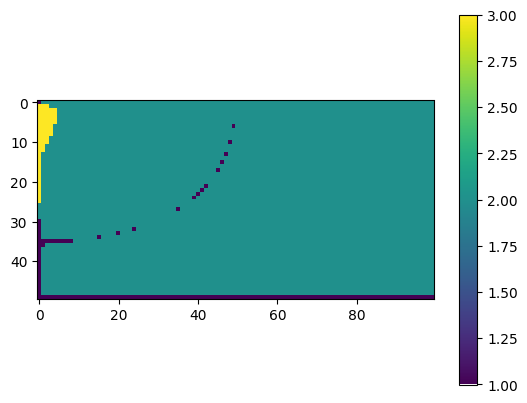

In [217]:
plt.imshow(results_grid)
plt.colorbar()

In [36]:
import numpy as np

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define the quaternion group Q8
Q8 = [
    np.eye(2),      # Identity
    -np.eye(2),     # -Identity
    1j * X,        # iX
    -1j * X,       # -iX
    1j * Y,        # iY
    -1j * Y,       # -iY
    1j * Z,        # iZ
    -1j * Z        # -iZ
]

[[6.  6.  3.5 3.5 3.5 3.5 6.  6. ]
 [6.  6.  3.5 3.5 3.5 3.5 6.  6. ]
 [5.5 5.5 2.  2.  2.  2.  5.5 5.5]
 [5.5 5.5 2.  2.  2.  2.  5.5 5.5]
 [5.  5.  3.5 3.5 3.5 3.5 5.  5. ]
 [5.  5.  3.5 3.5 3.5 3.5 5.  5. ]
 [5.5 5.5 5.  5.  5.  5.  5.5 5.5]
 [5.5 5.5 5.  5.  5.  5.  5.5 5.5]]


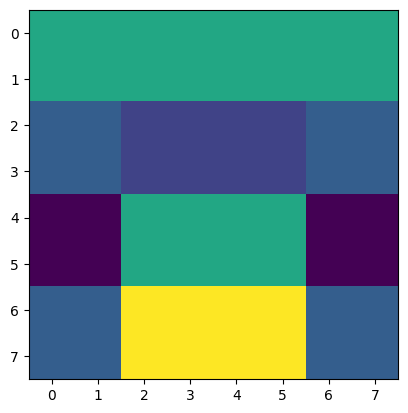

In [68]:
result1 = np.zeros((8,8))
for i,u1 in enumerate(Q8):
    for j,u2 in enumerate(Q8):
        result1[i,j] = np.round(total_payoff(final_state(Q8[i],Q8[j],J(np.pi/4),np.kron(C, C))),2)


result2 = np.zeros((8,8))
for i,u1 in enumerate(Q8):
    for j,u2 in enumerate(Q8):
        result2[i,j] = np.round(payoff_B(final_state(Q8[i],Q8[j],J(np.pi/4),np.kron(C, C))),2)
print(result1)
plt.show()
plt.imshow(result2)
plt.show()

In [63]:
print(result1)
print(result2)

[[3.  3.  0.5 0.5 0.5 0.5 3.  3. ]
 [3.  3.  0.5 0.5 0.5 0.5 3.  3. ]
 [4.  4.  1.  1.  1.  1.  4.  4. ]
 [4.  4.  1.  1.  1.  1.  4.  4. ]
 [5.  5.  0.5 0.5 0.5 0.5 5.  5. ]
 [5.  5.  0.5 0.5 0.5 0.5 5.  5. ]
 [4.  4.  0.  0.  0.  0.  4.  4. ]
 [4.  4.  0.  0.  0.  0.  4.  4. ]]
[[3.  3.  3.  3.  3.  3.  3.  3. ]
 [3.  3.  3.  3.  3.  3.  3.  3. ]
 [1.5 1.5 1.  1.  1.  1.  1.5 1.5]
 [1.5 1.5 1.  1.  1.  1.  1.5 1.5]
 [0.  0.  3.  3.  3.  3.  0.  0. ]
 [0.  0.  3.  3.  3.  3.  0.  0. ]
 [1.5 1.5 5.  5.  5.  5.  1.5 1.5]
 [1.5 1.5 5.  5.  5.  5.  1.5 1.5]]
